In [1]:
import os

os.chdir("/Users/xichenshe/IAI/scikit-learn/")
os.getcwd()

'/Users/xichenshe/IAI/scikit-learn'

In [2]:
from abc import ABC, abstractmethod
from functools import partial
import warnings

import numpy as np
from timeit import default_timer as time

from sklearn._loss.loss import (
    _LOSSES,
    BaseLoss,
    AbsoluteError,
    HalfBinomialLoss,
    HalfMultinomialLoss,
    HalfPoissonLoss,
    HalfSquaredError,
    PinballLoss,
)
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin, is_classifier
from sklearn.utils import check_random_state, resample
from sklearn.utils.validation import (
    check_is_fitted,
    check_consistent_length,
    _check_sample_weight,
)

from sklearn.utils._openmp_helpers import _openmp_effective_n_threads
from sklearn.utils.multiclass import check_classification_targets
from sklearn.metrics import check_scoring

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble._hist_gradient_boosting._gradient_boosting import _update_raw_predictions
from sklearn.ensemble._hist_gradient_boosting.common import Y_DTYPE, X_DTYPE, G_H_DTYPE

from sklearn.ensemble._hist_gradient_boosting.binning import _BinMapper
from sklearn.ensemble._hist_gradient_boosting.grower import TreeGrower

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


X, y = make_classification(n_samples=5000, n_features=5, n_informative=4, n_redundant=0, n_repeated=0, n_classes=2, random_state=23)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [4]:
from sklearn.ensemble import HistGradientBoostingClassifier


clf = HistGradientBoostingClassifier(max_depth=2, early_stopping=False, random_state=23, verbose=1)

## Breakdown of the `fit` method

In [5]:
X = X_train
y = y_train
sample_weight = None

In [6]:
fit_start_time = time()
acc_find_split_time = 0.0  # time spent finding the best splits
acc_apply_split_time = 0.0  # time spent splitting nodes
acc_compute_hist_time = 0.0  # time spent computing histograms
# time spent predicting X for gradient and hessians update
acc_prediction_time = 0.0
X, y = clf._validate_data(X, y, dtype=[X_DTYPE], force_all_finite=False)
y = clf._encode_y(y)
check_consistent_length(X, y)
# Do not create unit sample weights by default to later skip some
# computation
if sample_weight is not None:
    sample_weight = _check_sample_weight(sample_weight, X, dtype=np.float64)
    # TODO: remove when PDP supports sample weights
    clf._fitted_with_sw = True

rng = check_random_state(clf.random_state)

# When warm starting, we want to re-use the same seed that was used
# the first time fit was called (e.g. for subsampling or for the
# train/val split).
if not (clf.warm_start and clf._is_fitted()):
    clf._random_seed = rng.randint(np.iinfo(np.uint32).max, dtype="u8")

clf._validate_parameters()

# used for validation in predict
n_samples, clf._n_features = X.shape

clf.is_categorical_, known_categories = clf._check_categories(X)

# we need this stateful variable to tell raw_predict() that it was
# called from fit() (this current method), and that the data it has
# received is pre-binned.
# predicting is faster on pre-binned data, so we want early stopping
# predictions to be made on pre-binned data. Unfortunately the _scorer
# can only call predict() or predict_proba(), not raw_predict(), and
# there's no way to tell the scorer that it needs to predict binned
# data.
clf._in_fit = True

In [7]:
# `_openmp_effective_n_threads` is used to take cgroups CPU quotes
# into account when determine the maximum number of threads to use.
n_threads = _openmp_effective_n_threads()

if isinstance(clf.loss, str):
    clf._loss = clf._get_loss(sample_weight=sample_weight)
elif isinstance(clf.loss, BaseLoss):
    clf._loss = clf.loss

if clf.early_stopping == "auto":
    clf.do_early_stopping_ = n_samples > 10000
else:
    clf.do_early_stopping_ = clf.early_stopping

In [8]:
# create validation data if needed
clf._use_validation_data = clf.validation_fraction is not None
if clf.do_early_stopping_ and clf._use_validation_data:
    # stratify for classification
    # instead of checking predict_proba, loss.n_classes >= 2 would also work
    stratify = y if hasattr(clf._loss, "predict_proba") else None

    # Save the state of the RNG for the training and validation split.
    # This is needed in order to have the same split when using
    # warm starting.

    if sample_weight is None:
        X_train, X_val, y_train, y_val = train_test_split(
            X,
            y,
            test_size=clf.validation_fraction,
            stratify=stratify,
            random_state=clf._random_seed,
        )
        sample_weight_train = sample_weight_val = None
    else:
        # TODO: incorporate sample_weight in sampling here, as well as
        # stratify
        (
            X_train,
            X_val,
            y_train,
            y_val,
            sample_weight_train,
            sample_weight_val,
        ) = train_test_split(
            X,
            y,
            sample_weight,
            test_size=clf.validation_fraction,
            stratify=stratify,
            random_state=clf._random_seed,
        )
else:
    X_train, y_train, sample_weight_train = X, y, sample_weight
    X_val = y_val = sample_weight_val = None

In [9]:
n_bins = clf.max_bins + 1  # + 1 for missing values
clf._bin_mapper = _BinMapper(
    n_bins=n_bins,
    is_categorical=clf.is_categorical_,
    known_categories=known_categories,
    random_state=clf._random_seed,
    n_threads=n_threads,
)

In [10]:
X_binned_train = clf._bin_data(X_train, is_training_data=True, bin_thresholds=None)
if X_val is not None:
    X_binned_val = clf._bin_data(X_val, is_training_data=False)
else:
    X_binned_val = None

# Uses binned data to check for missing values
has_missing_values = (
    (X_binned_train == clf._bin_mapper.missing_values_bin_idx_)
    .any(axis=0)
    .astype(np.uint8)
)

if clf.verbose:
    print("Fitting gradient boosted rounds:")

n_samples = X_binned_train.shape[0]

Binning 0.000 GB of training data: 0.007 s
Fitting gradient boosted rounds:


In [11]:
clf._bin_mapper.bin_thresholds_[0][:10]

array([-2.54182129, -2.36895312, -2.22537003, -2.13057502, -2.05239781,
       -1.97522141, -1.90052693, -1.84954353, -1.7951716 , -1.74282237])

In [12]:
clf._bin_mapper.bin_thresholds_[3][:10]

array([-4.03672558, -3.72347704, -3.5660336 , -3.4256315 , -3.31027386,
       -3.23354503, -3.14732805, -3.06911889, -3.00062454, -2.93068974])

In [13]:
X_binned_train[:2000,]

array([[ 67,  44, 101, 149, 110],
       [ 22,  98,  26, 169,  11],
       [249, 138, 183,  28, 199],
       ...,
       [252,  88,  85,  87, 246],
       [207, 211, 133, 111, 113],
       [207,  68, 239, 208, 193]], dtype=uint8)

In [14]:
# Clear random state and score attributes
clf._clear_state()

# initialize raw_predictions: those are the accumulated values
# predicted by the trees for the training data. raw_predictions has
# shape (n_samples, n_trees_per_iteration) where
# n_trees_per_iterations is n_classes in multiclass classification,
# else 1.
# clf._baseline_prediction has shape (1, n_trees_per_iteration)
clf._baseline_prediction = clf._loss.fit_intercept_only(
    y_true=y_train, sample_weight=sample_weight_train
).reshape((1, -1))
raw_predictions = np.zeros(
    shape=(n_samples, clf.n_trees_per_iteration_),
    dtype=clf._baseline_prediction.dtype,
    order="F",
)
raw_predictions += clf._baseline_prediction

# predictors is a matrix (list of lists) of TreePredictor objects
# with shape (n_iter_, n_trees_per_iteration)
clf._predictors = predictors = []

# Initialize structures and attributes related to early stopping
clf._scorer = None  # set if scoring != loss
raw_predictions_val = None  # set if scoring == loss and use val
clf.train_score_ = []
clf.validation_score_ = []

if clf.do_early_stopping_:
    # populate train_score and validation_score with the
    # predictions of the initial model (before the first tree)

    if clf.scoring == "loss":
        # we're going to compute scoring w.r.t the loss. As losses
        # take raw predictions as input (unlike the scorers), we
        # can optimize a bit and avoid repeating computing the
        # predictions of the previous trees. We'll re-use
        # raw_predictions (as it's needed for training anyway) for
        # evaluating the training loss, and create
        # raw_predictions_val for storing the raw predictions of
        # the validation data.

        if clf._use_validation_data:
            raw_predictions_val = np.zeros(
                shape=(X_binned_val.shape[0], clf.n_trees_per_iteration_),
                dtype=clf._baseline_prediction.dtype,
                order="F",
            )

            raw_predictions_val += clf._baseline_prediction

        clf._check_early_stopping_loss(
            raw_predictions=raw_predictions,
            y_train=y_train,
            sample_weight_train=sample_weight_train,
            raw_predictions_val=raw_predictions_val,
            y_val=y_val,
            sample_weight_val=sample_weight_val,
            n_threads=n_threads,
        )
    else:
        clf._scorer = check_scoring(clf, clf.scoring)
        # _scorer is a callable with signature (est, X, y) and
        # calls est.predict() or est.predict_proba() depending on
        # its nature.
        # Unfortunately, each call to _scorer() will compute
        # the predictions of all the trees. So we use a subset of
        # the training set to compute train scores.

        # Compute the subsample set
        (
            X_binned_small_train,
            y_small_train,
            sample_weight_small_train,
        ) = clf._get_small_trainset(
            X_binned_train, y_train, sample_weight_train, clf._random_seed
        )

        clf._check_early_stopping_scorer(
            X_binned_small_train,
            y_small_train,
            sample_weight_small_train,
            X_binned_val,
            y_val,
            sample_weight_val,
        )
begin_at_stage = 0

In [15]:
raw_predictions

array([[-0.01200014],
       [-0.01200014],
       [-0.01200014],
       ...,
       [-0.01200014],
       [-0.01200014],
       [-0.01200014]])

In [16]:
# initialize gradients and hessians (empty arrays).
# shape = (n_samples, n_trees_per_iteration).
gradient, hessian = clf._loss.init_gradient_and_hessian(
    n_samples=n_samples, dtype=G_H_DTYPE, order="F"
)

In [17]:
# Update gradients and hessians, inplace
# Note that clf._loss expects shape (n_samples,) for
# n_trees_per_iteration = 1 else shape (n_samples, n_trees_per_iteration).
if clf._loss.constant_hessian:
    clf._loss.gradient(
        y_true=y_train,
        raw_prediction=raw_predictions,
        sample_weight=sample_weight_train,
        gradient_out=gradient,
        n_threads=n_threads,
    )
else:
    clf._loss.gradient_hessian(
        y_true=y_train,
        raw_prediction=raw_predictions,
        sample_weight=sample_weight_train,
        gradient_out=gradient,
        hessian_out=hessian,
        n_threads=n_threads,
    )

# Append a list since there may be more than 1 predictor per iter
predictors.append([])

In [18]:
# 2-d views of shape (n_samples, n_trees_per_iteration_) or (n_samples, 1)
# on gradient and hessian to simplify the loop over n_trees_per_iteration_.
if gradient.ndim == 1:
    g_view = gradient.reshape((-1, 1))
    h_view = hessian.reshape((-1, 1))
else:
    g_view = gradient
    h_view = hessian

In [19]:
g_view[:10,]

array([[ 0.497],
       [ 0.497],
       [-0.503],
       [ 0.497],
       [-0.503],
       [-0.503],
       [ 0.497],
       [ 0.497],
       [ 0.497],
       [-0.503]], dtype=float32)

In [20]:
h_view[:10,]

array([[0.249991],
       [0.249991],
       [0.249991],
       [0.249991],
       [0.249991],
       [0.249991],
       [0.249991],
       [0.249991],
       [0.249991],
       [0.249991]], dtype=float32)

In [21]:
g_view[-10:,]

array([[-0.503],
       [ 0.497],
       [ 0.497],
       [-0.503],
       [ 0.497],
       [-0.503],
       [-0.503],
       [ 0.497],
       [-0.503],
       [ 0.497]], dtype=float32)

In [22]:
k = 0

grower = TreeGrower(
    X_binned=X_binned_train,
    gradients=g_view[:, k],
    hessians=h_view[:, k],
    n_bins=n_bins,
    n_bins_non_missing=clf._bin_mapper.n_bins_non_missing_,
    has_missing_values=has_missing_values,
    is_categorical=clf.is_categorical_,
    monotonic_cst=clf.monotonic_cst,
    max_leaf_nodes=clf.max_leaf_nodes,
    max_depth=clf.max_depth,
    min_samples_leaf=clf.min_samples_leaf,
    l2_regularization=clf.l2_regularization,
    shrinkage=clf.learning_rate,
    n_threads=n_threads,
)

In [23]:
np.asarray(grower.root.histograms)[0][:10]

array([(-0.0480001 , 3.999856, 16), (-0.0480001 , 3.999856, 16),
       ( 1.95199996, 3.999856, 16), (-1.54500014, 3.749865, 15),
       (-1.04800013, 3.999856, 16), ( 0.95199993, 3.999856, 16),
       ( 3.45500001, 3.749865, 15), (-2.04800016, 3.999856, 16),
       ( 1.95199996, 3.999856, 16), (-3.5450002 , 3.749865, 15)],
      dtype=[('sum_gradients', '<f8'), ('sum_hessians', '<f8'), ('count', '<u4')])

In [24]:
grower.root.__dict__

{'depth': 0,
 'sample_indices': <MemoryView of 'ndarray' at 0x1265e66c0>,
 'n_samples': 4000,
 'sum_gradients': -2.396106719970703e-05,
 'sum_hessians': 999.9639987945557,
 'value': 0,
 'is_leaf': False,
 'children_lower_bound': -inf,
 'children_upper_bound': inf,
 'partition_start': 0,
 'partition_stop': 4000,
 'histograms': <MemoryView of 'ndarray' at 0x1265e6ba0>,
 'split_info': <sklearn.ensemble._hist_gradient_boosting.splitting.SplitInfo at 0x126619490>}

In [25]:
grower.root.split_info.__dict__

{'gain': 764.4530248414894,
 'feature_idx': 4,
 'bin_idx': 195,
 'missing_go_to_left': 0,
 'sum_gradient_left': 368.7779925763607,
 'sum_hessian_left': 768.472333073616,
 'sum_gradient_right': -368.7780165374279,
 'sum_hessian_right': 231.49166572093964,
 'n_samples_left': 3074,
 'n_samples_right': 926,
 'value_left': -0.479884540672245,
 'value_right': 1.59305094370864,
 'is_categorical': 0,
 'left_cat_bitset': None}

### Build child nodes

In [46]:
from heapq import heappush, heappop
import numpy as np
from timeit import default_timer as time
import numbers


node = heappop(grower.splittable_nodes)

In [47]:
(
    sample_indices_left,
    sample_indices_right,
    right_child_pos,
) = grower.splitter.split_indices(node.split_info, node.sample_indices)

In [48]:
depth = node.depth + 1
n_leaf_nodes = len(grower.finalized_leaves) + len(grower.splittable_nodes)
n_leaf_nodes += 2

In [49]:
from sklearn.ensemble._hist_gradient_boosting.grower import TreeNode


left_child_node = TreeNode(
    depth,
    sample_indices_left,
    node.split_info.sum_gradient_left,
    node.split_info.sum_hessian_left,
    value=node.split_info.value_left,
)
right_child_node = TreeNode(
    depth,
    sample_indices_right,
    node.split_info.sum_gradient_right,
    node.split_info.sum_hessian_right,
    value=node.split_info.value_right,
)

node.right_child = right_child_node
node.left_child = left_child_node

In [50]:
# set start and stop indices
left_child_node.partition_start = node.partition_start
left_child_node.partition_stop = node.partition_start + right_child_pos
right_child_node.partition_start = left_child_node.partition_stop
right_child_node.partition_stop = node.partition_stop

if not grower.has_missing_values[node.split_info.feature_idx]:
    # If no missing values are encountered at fit time, then samples
    # with missing values during predict() will go to whichever child
    # has the most samples.
    node.split_info.missing_go_to_left = (
        left_child_node.n_samples > right_child_node.n_samples
    )

grower.n_nodes += 2
grower.n_categorical_splits += node.split_info.is_categorical

In [51]:
grower.max_depth is not None and depth == grower.max_depth

True

In [52]:
# if grower.max_leaf_nodes is not None and n_leaf_nodes == grower.max_leaf_nodes:
#     grower._finalize_leaf(left_child_node)
#     grower._finalize_leaf(right_child_node)
#     grower._finalize_splittable_nodes()
#     # return left_child_node, right_child_node

if grower.max_depth is not None and depth == grower.max_depth:
    grower._finalize_leaf(left_child_node)
    grower._finalize_leaf(right_child_node)
    # return left_child_node, right_child_node
else:
    # We will compute the histograms of both nodes even if one of them
    # is a leaf, since computing the second histogram is very cheap
    # (using histogram subtraction).
    n_samples_left = left_child_node.sample_indices.shape[0]
    n_samples_right = right_child_node.sample_indices.shape[0]
    if n_samples_left < n_samples_right:
        smallest_child = left_child_node
        largest_child = right_child_node
    else:
        smallest_child = right_child_node
        largest_child = left_child_node

    smallest_child.histograms = grower.histogram_builder.compute_histograms_brute(
        smallest_child.sample_indices
    )
    largest_child.histograms = (
        grower.histogram_builder.compute_histograms_subtraction(
            node.histograms, smallest_child.histograms
        )
    )
    grower._compute_best_split_and_push(left_child_node)
    grower._compute_best_split_and_push(right_child_node)

    # # For LEAF nodes, release memory used by histograms as they are no longer needed
    # # since they won't be split.
    # for child in (left_child_node, right_child_node):
    #     if child.is_leaf:
    #         del child.histograms
    
    # # For INTERNAL nodes, release memory used by histograms as they are no longer needed
    # # once children histograms have been computed.
    # del node.histograms

# if left_child_node.n_samples < grower.min_samples_leaf * 2:
#     grower._finalize_leaf(left_child_node)
# if right_child_node.n_samples < grower.min_samples_leaf * 2:
#     grower._finalize_leaf(right_child_node)

In [53]:
grower.splittable_nodes

[]

In [61]:
grower.root.left_child.split_info.__dict__

{'gain': 775.8972238270022,
 'feature_idx': 1,
 'bin_idx': 165,
 'missing_go_to_left': True,
 'sum_gradient_left': 608.0060061514378,
 'sum_hessian_left': 499.48201739788055,
 'sum_gradient_right': -239.22801357507706,
 'sum_hessian_right': 268.9903156757355,
 'n_samples_left': 1998,
 'n_samples_right': 1076,
 'value_left': -1.2172730648421093,
 'value_right': 0.8893554884089712,
 'is_categorical': 0,
 'left_cat_bitset': None}

### Make predictors

In [54]:
import pandas as pd


pd.DataFrame(grower.make_predictor(clf._bin_mapper.bin_thresholds_).nodes)

,value,count,feature_idx,num_threshold,missing_go_to_left,left,right,gain,depth,is_leaf,bin_threshold,is_categorical,bitset_idx
0,0.000000,4000,4,0.394379,1,1,4,764.453025,0,0,195,0,0
1,-0.479885,3074,1,0.154310,1,2,3,775.897224,1,0,165,0,0
2,-1.217273,1998,0,0.000000,0,0,0,-1.000000,2,1,0,0,0
3,0.889355,1076,0,0.000000,0,0,0,-1.000000,2,1,0,0,0
4,1.593051,926,3,1.029580,1,5,6,43.621109,1,0,216,0,0
5,1.720982,852,0,0.000000,0,0,0,-1.000000,2,1,0,0,0
6,0.120112,74,0,0.000000,0,0,0,-1.000000,2,1,0,0,0


In [56]:
X_train[:, 0]

array([-0.59138517, -1.34886332,  1.9947005 , ...,  0.82364599,
        1.88878201,  1.09721381])

In [57]:
import matplotlib.pyplot as plt

(array([1.000e+00, 1.500e+01, 1.350e+02, 4.580e+02, 9.790e+02, 1.196e+03,
        8.050e+02, 3.340e+02, 6.600e+01, 1.100e+01]),
 array([-4.05482491, -3.29252876, -2.53023261, -1.76793646, -1.00564031,
        -0.24334416,  0.51895199,  1.28124814,  2.04354429,  2.80584044,
         3.56813659]),
 <BarContainer object of 10 artists>)

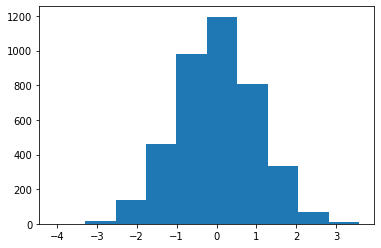

In [58]:
plt.hist(X_train[:, 0])

In [59]:
np.sum(X_train[:, 0] <= 0.154)

2237

In [60]:
np.sum(X_train[:, 0] <= -0.027)

1942